# Finding and Loading a Dataset
---

## Libraries & Functions

In [1]:
import os
import requests
from f_postgres import pgSQL
PG = pgSQL()
T = PG.T
T.Addr_Parsing(T)
T.requests = requests

def download_file(url,save_path):
    
    _dir = save_path[:save_path.rfind('/')]
    if not os.path.exists(_dir):
        os.makedirs(_dir)
        
    with open(save_path, 'wb') as handle:
        response = requests.get(url, stream=True)

        if not response.ok:
            # Something went wrong
            print 'error'

        for block in response.iter_content(1024):
            if not block:
                break

            handle.write(block)
            handle.flush()
    return True

def read_json_from_url_response(url):
    r = requests.get(url)
    # print r.status_code
    # print r.text
    g = r.text
    g = g.replace('true',"'true'")
    a = eval(g)
    return a

def to_sql(cmd):
    T.conn.set_isolation_level(0)
    T.cur.execute(cmd)

def custom_geoseries_plot(s):
    # s=T.gd.GeoSeries(A)
    colormap='Set1'
    axes=None
    linewidth=1.0
    figsize=(8,8)

    import matplotlib.pyplot as plt
    if axes is None:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_aspect('equal')
    else:
        ax = axes
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xticks(rotation='vertical')
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    color = T.gd.plotting.gencolor(len(s), colormap=colormap)
    for geom in s:
        if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
            T.gd.plotting.plot_multipolygon(ax, geom, facecolor=next(color), linewidth=linewidth)
        elif geom.type == 'LineString' or geom.type == 'MultiLineString':
            T.gd.plotting.plot_multilinestring(ax, geom, color=next(color), linewidth=linewidth)
        elif geom.type == 'Point':
            T.gd.plotting.plot_point(ax, geom)
    plt.ticklabel_format(style='plain')
    plt.grid()
    plt.draw()
    

%reload_ext sql
%sql postgresql://$T.DB_USER:$T.DB_PW@$T.DB_HOST:$T.DB_PORT/$T.DB_NAME
%config SqlMagic.feedback=True
%config SqlMagic.autopandas=True
%config SqlMagic.short_errors=False

## Check and review shape files from [NYC Apple Bytes](http://www.nyc.gov/html/dcp/html/bytes/applbyte.shtml#geocoding_application)

In [2]:
from f_nyc_data import NYC_Data
ND = NYC_Data()
df = ND.get_latest_links_from_nyc_bytes()

import re
shape_files = df[(df.Data_Set.str.contains('mappluto',flags=re.I)) & (df.file_type=='zip')]
shape_files

,Data_Set,Date,link,file_type
10,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/download/bytes/nyc_pluto_15v1.zip,zip
12,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/download/bytes/bx_mappluto_15v1.zip,zip
14,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/download/bytes/bk_mappluto_15v1.zip,zip
15,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/download/bytes/mn_mappluto_15v1.zip,zip
16,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/download/bytes/qn_mappluto_15v1.zip,zip
17,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/download/bytes/si_mappluto_15v1.zip,zip


In [3]:
# Download and extract manhattan shape files

link = shape_files[shape_files.link.str.contains('mn_')].link.iloc[0]

save_dir = 'NYC_data/'
save_path = save_dir + '2015.06.01_mn_shape_file.zip'
assert download_file(link, save_path)==True

import zipfile
z = zipfile.ZipFile(save_path)
z.extractall()
for it in z.filelist:
    print 'Extracted:',it.filename

Extracted: Manhattan/MN_Dcp_Mappinglot.dbf
Extracted: Manhattan/MN_Dcp_Mappinglot.prj
Extracted: Manhattan/MN_Dcp_Mappinglot.sbn
Extracted: Manhattan/MN_Dcp_Mappinglot.sbx
Extracted: Manhattan/MN_Dcp_Mappinglot.shp
Extracted: Manhattan/MN_Dcp_Mappinglot.shp.xml
Extracted: Manhattan/MN_Dcp_Mappinglot.shx
Extracted: Manhattan/mn_pluto.dbf
Extracted: Manhattan/mn_pluto.dbf.xml
Extracted: Manhattan/MNMapPLUTO.BBL.atx
Extracted: Manhattan/MNMapPLUTO.CD.atx
Extracted: Manhattan/MNMapPLUTO.dbf
Extracted: Manhattan/MNMapPLUTO.LandUse.atx
Extracted: Manhattan/MNMapPLUTO.prj
Extracted: Manhattan/MNMapPLUTO.sbn
Extracted: Manhattan/MNMapPLUTO.sbx
Extracted: Manhattan/MNMapPLUTO.shp
Extracted: Manhattan/MNMapPLUTO.shp.xml
Extracted: Manhattan/MNMapPLUTO.shx
Extracted: Manhattan/MNMapPLUTO.ZoneDist1.atx
Extracted: Manhattan/PLUTODD15v1.pdf


In [4]:
# Determine source SRID -- Check help file with shape file

df[(df.Data_Set.str.contains('mappluto',flags=re.I)) & (df.file_type=='pdf')]

,Data_Set,Date,link,file_type
11,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/pdf/bytes/pluto_datadictionary.pdf?r=2,pdf
13,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/pdf/bytes/meta_mappluto.pdf?r=2,pdf
18,MapPLUTOTM,March 2015- June 2015,http://www.nyc.gov/html/dcp/pdf/bytes/meta_mappluto.pdf?r=1,pdf


In [5]:
info_link =  df[(df.Data_Set.str.contains('mappluto',flags=re.I)) & 
                (df.link.str.contains('meta_mappluto.pdf'))].link.iloc[0]
pdf_path = save_dir + 'pluto_info.pdf'
assert download_file(info_link, pdf_path)

!pdftotext $pdf_path - | grep -B 10 -A 10 -i 'epsg'


["NAD_1983_StatePlane_New_York_Long_Island_FIPS_3104_Feet",GEOGCS
["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID
["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT
["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER
["False_Easting",984250.0],PARAMETER["False_Northing",0.0],PARAMETER
["Central_Meridian",-74.0],PARAMETER
["Standard_Parallel_1",40.66666666666666],PARAMETER
["Standard_Parallel_2",41.03333333333333],PARAMETER
["Latitude_Of_Origin",40.16666666666666],UNIT
["Foot_US",0.3048006096012192],AUTHORITY["EPSG",2263]]
REFERENCE SYSTEM IDENTIFIER
VALUE 2263
CODESPACE EPSG
VERSION 7.11.2
Hide Spatial Reference ▲

Spatial Data Properties ►
ARCGIS FEATURE CLASS PROPERTIES
►
FEATURE CLASS NAME MapPLUTO
* FEATURE TYPE Simple
* GEOMETRY TYPE Polygon
* HAS TOPOLOGY FALSE


## Load data into database

In [6]:
# The help file indicates that the shape file was created using SRID '2263'
# Reproject onto EPSG:4326 if matching GPS coordinates between shapefile and Google Maps is important

import getpass
# Convert shape file to sql load file
sql_file = save_dir + 'mn_pluto.sql'
log_f = save_dir + 'shp_import.log'
pw = getpass.getpass('root password?\t')

# Pick title for table
tbl_name = 'mn_pluto'

# Might need to disable event trigger
!echo "ALTER EVENT TRIGGER missing_primary_key_trigger DISABLE;" > $sql_file
!shp2pgsql -s 2263:4326 Manhattan/MNMapPLUTO.shp $tbl_name >> $sql_file
!echo "ALTER EVENT TRIGGER missing_primary_key_trigger ENABLE;" >> $sql_file

!echo "$pw" | sudo -S --prompt='' su postgres -c "psql -h $T.DB_HOST -p $T.DB_PORT $T.DB_NAME < $sql_file" > $log_f

root password?	········
Shapefile type: Polygon
Postgis type: MULTIPOLYGON[2]


## Quick Check:  Find Herald Square and Compare with Google Maps

In [7]:
# Query all content (by concatenating columns), do open-ended search 

qry="""
select * from
( select *,regexp_replace(r::text,','::text,' '::text,'g') concat_cols from %s AS r ) f
where concat_cols ilike '%%%%herald%%%%' and concat_cols ilike '%%%%park%%%%'
""" % tbl_name
%sql postgres@$T.DB_NAME $qry

1 rows affected.


,gid,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healtharea,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,ltdheight,allzoning1,allzoning2,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exemptland,exempttot,yearbuilt,builtcode,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,version,mappluto_f,shape_leng,shape_area,geom,concat_cols
0,5723,MN,810,45,105,109,1011,02,4,10001,E026,14,5200,1 HERALD SQUARE,PARK,None,None,None,None,None,None,None,None,PARK,None,N,Q1,09,0,C,PARKS AND RECREATION,8612,0,0,0,0,0,0,0,0,0,7,1,0E-11,0,0,28.2500000000,207.750000000,0E-11,0E-11,None,0,Y,3,5,2452500.00000,2747700.00000,2452500.00000,2747700.00000,0,None,0,0,None,None,0E-11,0E-11,0E-11,0E-11,1,1008100045.00,0,0109,987672,212628,8d,None,105N035,10305,None,0E-11,None,1,15v1,0,523.994927473,9114.78340059,0106000020E6100000010000000103000000010000004D0000001115DC69387F52C05C6C09DDFC5F4440BC3CC66D387F52C0B657EDDCFC5F4440A7E1BF71387F52C0601E54DDFC5F44404DE3AD75387F52C01C913CDEFC5F444092347F79387F52C03A81A5DFFC5F444045880B7D387F52C0726B7EE1FC5F4440BB...,"(5723 MN 810 45 105 109 1011 02 4 10001 E026 14 5200 ""1 HERALD SQUARE"" PARK PARK N Q1 09 0 C ""PARKS AND RECREATION"" 8612 0 0 0 0 0 0 0 0 0 7 1 0.00000000000 0 0 28.2500000000 207.750000000 0.00000000000 0.00000000000 0 Y 3 5 2452500.000..."



Centroid Located at (-73.987646604,40.7502929962)



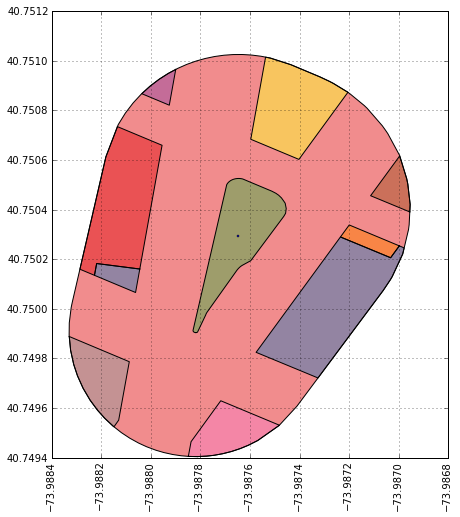

In [8]:
# Plot geographic figures and compare with google

%matplotlib inline
A = []

outline = T.gd.read_postgis("""SELECT ST_Buffer(ST_ConvexHull((ST_Collect(f.the_geom))), .0005) as geom 
                    FROM ( SELECT *, (ST_Dump(geom)).geom as the_geom 
                    FROM %s where address = '1 HERALD SQUARE' ) As f""" % tbl_name, T.eng)
A.extend(outline.geom)

touching_geoms =   """
        select st_intersection(geom,outline_geom) geom 
        from 
            %s,
            (select ST_GeomFromEWKT('SRID=4326;%s') outline_geom) as t
        where geom is not null""".replace('\n',' ') % (tbl_name,str(outline.geom[0]))
A.extend(T.gd.read_postgis(touching_geoms,T.eng).geom)

centroid = T.gd.read_postgis(""" SELECT st_centroid(geom) geom 
                                 FROM %s where address = '1 HERALD SQUARE' 
                             """ % tbl_name, T.eng)
A.extend(centroid.geom)

XY = tuple(centroid.bounds.iloc[0][:2])
print '\nCentroid Located at (%s,%s)\n' % XY

# Typically a command like "T.gd.GeoSeries(A).plot()" works well enough
custom_geoseries_plot(T.gd.GeoSeries(A))

## End Notes

Compare with [Google Maps](https://www.google.com/maps/place/Herald+Square+NYC).  Coordinates are available by:  

    Right Click -> What's Here
A [cheatsheet for postGIS](http://www.postgis.us/downloads/postgis21_cheatsheet.pdf) may be handy.

In this instance, the data was loaded into pgSQL as a base layer on which to integrate more data. 
But, just loading and analyzing shapefiles can be done without pgSQL ([see an exampleii here](https://github.com/geopandas/geopandas#examples)).